In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

Read the data

In [2]:
coin_vals = np.array([5, 10, 20, 50, 100, 200, 500])

X = []
y = []

for val in coin_vals:
    path = os.path.join('data', str(val))
    for file in os.listdir(path):
        if file.endswith(".png"):
            imgdata = plt.imread(os.path.join(path, file))[0:100, 0:100, 0]
            X.append(imgdata)
            y.append(coin_vals == val)

Xtrain = np.reshape(np.array(X), [-1, 100, 100, 1])
ytrain = np.array(y, dtype=np.float32)


Create our model

In [13]:
l2_lambda = 0.05

sess = tf.Session()

x = tf.placeholder(tf.float32, [None, 100, 100, 1])
y_ = tf.placeholder(tf.float32, [None, 7])
keep_prob = tf.placeholder_with_default(1.0, None)

W1 = tf.Variable(tf.truncated_normal([20, 20, 1, 10], stddev=0.3))
b1 = tf.Variable(tf.constant(0.3 * np.ones([50, 50, 10]), dtype=tf.float32))

W2 = tf.Variable(tf.truncated_normal([5, 5, 10, 16], stddev=0.3))
b2 = tf.Variable(tf.constant(0.3 * np.ones([25, 25, 16]), dtype=tf.float32))

W3 = tf.Variable(tf.truncated_normal([400, 7], stddev=0.3))
b3 = tf.Variable(tf.constant(0.3 * np.ones([7]), dtype=tf.float32))

def pipeline(x):
    h1 = x
    h1 = tf.nn.max_pool(h1, [1, 2, 2, 1], [1, 2, 2, 1], 'VALID')
    h1 = tf.nn.conv2d(h1, W1, [1, 1, 1, 1], 'SAME') + b1
    h1 = tf.nn.relu(h1)
    h1 = tf.nn.dropout(h1, keep_prob)

    h2 = tf.nn.max_pool(h1, [1, 2, 2, 1], [1, 2, 2, 1], 'VALID')
    h2 = tf.nn.conv2d(h2, W2, [1, 1, 1, 1], 'SAME') + b2
    h2 = tf.nn.relu(h2)
    h2 = tf.nn.dropout(h2, keep_prob)

    out = tf.nn.max_pool(h2, [1, 5, 5, 1], [1, 5, 5, 1], 'VALID')
    out = tf.reshape(out, [-1, 5*5*16])
    out = tf.matmul(out, W3) + b3

    return out

y = pipeline(x)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y)) +\
       l2_lambda * tf.add_n([tf.nn.l2_loss(x) for x in [W1, W2, W3]])
train_task = tf.train.GradientDescentOptimizer(0.05).minimize(cost)

Train & test the model

In [14]:
batch_size = 200

sess.run(tf.global_variables_initializer())

data_len = len(X)
perm = np.random.permutation(range(data_len))

train_set = perm[0:(data_len * 8 // 10)]
test_set = perm[(data_len * 8 // 10):(data_len * 9 // 10)]
val_set = perm[(data_len * 9 // 10):]

for epoch in range(1000):
    batch = np.random.permutation(train_set)[:batch_size]
    X_in = Xtrain[batch]
    y_in = ytrain[batch]
    sess.run(train_task, {x: X_in, y_: y_in, keep_prob: 0.85})
    if epoch % 50 == 0:
        test_X = Xtrain[test_set]
        test_y = ytrain[test_set]
        print("Test set accuracy", np.mean(np.argmax(sess.run(y, {x: test_X}), 1) == np.argmax(test_y, 1)))
        
val_X = Xtrain[test_set]
val_y = ytrain[test_set]

print("Validation set accuracy", np.mean(np.argmax(sess.run(y, {x: val_X}), 1) == np.argmax(val_y, 1)))

Test set accuracy 0.157894736842
Test set accuracy 0.236842105263
Test set accuracy 0.263157894737
Test set accuracy 0.328947368421
Test set accuracy 0.394736842105
Test set accuracy 0.565789473684
Test set accuracy 0.631578947368
Test set accuracy 0.736842105263
Test set accuracy 0.789473684211
Test set accuracy 0.75
Test set accuracy 0.842105263158
Test set accuracy 0.763157894737
Test set accuracy 0.763157894737
Test set accuracy 0.802631578947


KeyboardInterrupt: 

Try different images

array([[ 0.45970827, -0.77102995, -0.45071507, -1.99535656,  1.03625584,
         1.62199271,  2.18676019]], dtype=float32)

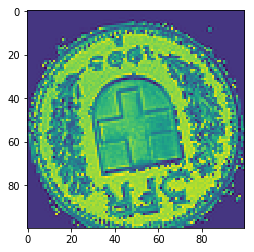

In [10]:
%matplotlib inline
plt.imshow(np.reshape(val_X[1], [100, 100]))

sess.run(y, {x: [val_X[1]]})

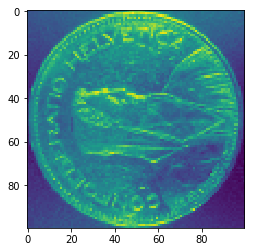

In [15]:
imgdata1 = plt.imread('/home/nikos/5fr.jpg')
imgdata1 = np.reshape(np.mean(imgdata1, 2), [100, 100, 1])
plt.imshow(np.reshape(imgdata1, [100, 100]))

In [12]:
%matplotlib inline
sess.run((y), {x: [imgdata1]})

array([[ 25.37663651, -24.42695236,   1.7913543 , -70.81292725,
         49.13708878,  -3.6431787 ,  25.04051018]], dtype=float32)